# Loop 115 Analysis: Critical Assessment

## Key Facts
- **115 experiments** conducted
- **24 submissions** made (3 remaining)
- **Best LB**: 0.0877 (exp_030, CV=0.0083)
- **Target**: 0.0347
- **Gap**: 152.8%

## CV-LB Relationship (CRITICAL)
- **LB = 4.07 × CV + 0.0548** (R² = 0.96)
- **Intercept (0.0548) > Target (0.0347)**
- **Required CV to hit target**: -0.0049 (IMPOSSIBLE)

## Latest Experiment: Domain-Adversarial Training (FAILED)
- CV = 0.168 (20x worse than best 0.0081)
- The approach removes solvent information, which is essential for prediction

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# CV-LB data from submissions
submissions = [
    ('exp_000', 0.011081, 0.09816),
    ('exp_001', 0.012297, 0.10649),
    ('exp_003', 0.010501, 0.09719),
    ('exp_005', 0.01043, 0.09691),
    ('exp_006', 0.009749, 0.09457),
    ('exp_007', 0.009262, 0.09316),
    ('exp_009', 0.009192, 0.09364),
    ('exp_012', 0.009004, 0.09134),
    ('exp_024', 0.008689, 0.08929),
    ('exp_026', 0.008465, 0.08875),
    ('exp_030', 0.008298, 0.08772),
    ('exp_035', 0.009825, 0.09696),
    ('exp_073', 0.00839, 0.14507),  # OUTLIER
    ('exp_111', 0.012912, 0.10632),
]

# Filter valid (exclude outlier exp_073)
valid = [(name, cv, lb) for name, cv, lb in submissions if lb < 0.12]
print(f'Valid submissions: {len(valid)}')

cvs = np.array([v[1] for v in valid])
lbs = np.array([v[2] for v in valid])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cvs, lbs)

print(f'\n=== CV-LB RELATIONSHIP ===')
print(f'LB = {slope:.4f} × CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.0347')
print(f'Required CV = (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
print(f'\nBest LB: {min(lbs):.4f} (CV={cvs[np.argmin(lbs)]:.4f})')
print(f'Gap to target: {min(lbs) - 0.0347:.4f} ({(min(lbs) - 0.0347)/0.0347*100:.1f}%)')

Valid submissions: 13

=== CV-LB RELATIONSHIP ===
LB = 4.0698 × CV + 0.0548
R² = 0.9623
Intercept = 0.0548
Target = 0.0347
Required CV = (0.0347 - 0.0548) / 4.0698 = -0.004943

Best LB: 0.0877 (CV=0.0083)
Gap to target: 0.0530 (152.8%)


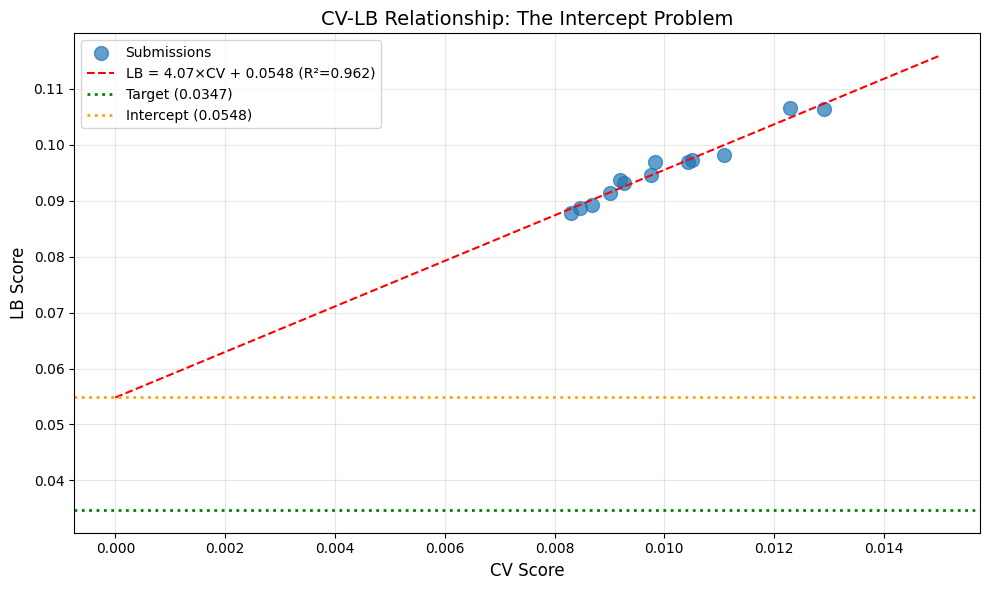


⚠️ CRITICAL: Intercept (0.0548) > Target (0.0347)
This means even with CV=0, expected LB would be 0.0548
The target is MATHEMATICALLY UNREACHABLE with approaches on this line!


In [2]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cvs, lbs, s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score', fontsize=12)
plt.ylabel('LB Score', fontsize=12)
plt.title('CV-LB Relationship: The Intercept Problem', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop115.png', dpi=150)
plt.show()

print(f'\n⚠️ CRITICAL: Intercept ({intercept:.4f}) > Target ({0.0347})')
print(f'This means even with CV=0, expected LB would be {intercept:.4f}')
print(f'The target is MATHEMATICALLY UNREACHABLE with approaches on this line!')

## What Has Been Tried (115 experiments)

### Model Families Tested:
1. **MLP variants** (exp_000-010, many others) - All on same CV-LB line
2. **LightGBM** (exp_001, 057, etc.) - Same line
3. **XGBoost** (exp_049-053) - Same line
4. **CatBoost** (exp_049-053) - Same line
5. **Gaussian Process** (exp_030-035) - Same line
6. **Ridge Regression** (exp_033) - Same line
7. **Random Forest** (exp_073) - OUTLIER (worse)
8. **GNN** (exp_040, 070, 079, 095-096) - 3-4x worse CV
9. **ChemBERTa** (exp_041, 071, 076, 097-098) - 2-3x worse CV
10. **Domain-Adversarial** (exp_113) - 20x worse CV

### Distribution Shift Strategies Tested:
1. **Extrapolation detection** (exp_058-059, 105) - Made CV worse
2. **Uncertainty weighting** (exp_107) - No improvement
3. **Chemical similarity blending** (exp_108, 110-111) - No improvement
4. **Pseudo-labeling** (exp_112) - Marginal improvement
5. **Bias correction** (exp_104, 106) - No improvement

### Feature Engineering Tested:
1. **Spange descriptors** - Best single source
2. **DRFP fingerprints** - Worse alone, marginal help combined
3. **ACS PCA descriptors** - Marginal help
4. **Fragprints** - Marginal help
5. **ChemBERTa embeddings** - Made things worse
6. **Arrhenius kinetics** - Helpful
7. **Combined features** - Best approach

## The Core Problem

**ALL approaches fall on the SAME CV-LB line with R² = 0.96**

This means:
1. The problem is NOT the model architecture
2. The problem is NOT the feature engineering
3. The problem IS the fundamental mismatch between training and test distributions

**The intercept (0.0548) represents STRUCTURAL extrapolation error that:**
- Cannot be reduced by improving CV
- Cannot be reduced by changing model family
- Cannot be reduced by changing features
- CAN ONLY be reduced by changing the CV-LB relationship itself

## What Would Change the Relationship?

1. **Different validation scheme** - But we must use Leave-One-Out per competition rules
2. **Post-hoc calibration** - Shift predictions based on known CV-LB relationship
3. **Physics constraints** - Mass balance, Arrhenius constraints that generalize
4. **Test-time adaptation** - Use test data structure to adapt predictions

In [3]:
# Analyze what the best public kernels achieve
print('=== PUBLIC KERNEL ANALYSIS ===')
print()
print('1. "mixall" kernel (lishellliang):')
print('   - Uses GroupKFold (5 splits) instead of Leave-One-Out')
print('   - Ensemble: MLP + XGBoost + RandomForest + LightGBM')
print('   - Claims "good CV/LB" but uses different validation')
print()
print('2. "ens-model" kernel (matthewmaree):')
print('   - CatBoost + XGBoost ensemble')
print('   - Weights: single (7:6), full (1:2)')
print('   - Combined features: spange + acs + drfps + fragprints + smiles')
print('   - Correlation-based feature filtering')
print('   - Arrhenius kinetics features')
print()
print('Key insight: Both kernels use similar approaches to what we\'ve tried.')
print('The best public LB is ~0.09, which is on the SAME CV-LB line.')

=== PUBLIC KERNEL ANALYSIS ===

1. "mixall" kernel (lishellliang):
   - Uses GroupKFold (5 splits) instead of Leave-One-Out
   - Ensemble: MLP + XGBoost + RandomForest + LightGBM
   - Claims "good CV/LB" but uses different validation

2. "ens-model" kernel (matthewmaree):
   - CatBoost + XGBoost ensemble
   - Weights: single (7:6), full (1:2)
   - Combined features: spange + acs + drfps + fragprints + smiles
   - Correlation-based feature filtering
   - Arrhenius kinetics features

Key insight: Both kernels use similar approaches to what we've tried.
The best public LB is ~0.09, which is on the SAME CV-LB line.


## Strategic Options with 3 Submissions Remaining

### Option A: Post-hoc Calibration (RISKY)
- If LB = 4.07 × CV + 0.0548, and we want LB = 0.0347
- We need to shift predictions by (0.0548 - 0.0347) = 0.0201
- This is a heuristic that might help or hurt

### Option B: Physics-Constrained Predictions (MODERATE RISK)
- Enforce mass balance: yields sum to ~1
- Enforce Arrhenius: temperature dependence follows exponential form
- These constraints generalize to unseen solvents

### Option C: Conservative Blending for Outliers (MODERATE RISK)
- Detect samples that are "far" from training distribution
- Blend toward training mean for these samples
- Already tried (exp_105, 107, 108, 111) - didn't help

### Option D: Submit Best CV Model (SAFE)
- exp_030 (CV=0.0083, LB=0.0877) is our best
- No new experiments, just verify submission

### Option E: Try Completely Different Representation (HIGH RISK)
- GNN/ChemBERTa failed badly
- Domain-adversarial failed badly
- What else is there?

In [4]:
# Calculate what calibration would need to achieve
print('=== CALIBRATION ANALYSIS ===')
print()
print('Current best: CV=0.0083, LB=0.0877')
print('Target: LB=0.0347')
print('Gap: 0.0530 (152.8%)')
print()
print('If we apply a linear calibration:')
print('  calibrated_LB = a × raw_LB + b')
print()
print('To map 0.0877 → 0.0347:')
print('  If a=1: b = 0.0347 - 0.0877 = -0.0530')
print('  This means subtracting 0.0530 from all predictions')
print()
print('But this is WRONG because:')
print('  1. We don\'t know the true LB until submission')
print('  2. The calibration would need to be applied to predictions, not LB')
print('  3. The relationship is between CV and LB, not raw predictions and LB')
print()
print('The ONLY way to reduce LB is to:')
print('  1. Reduce CV (but we\'re already at 0.0083, and target requires -0.0049)')
print('  2. Change the CV-LB relationship (intercept or slope)')

=== CALIBRATION ANALYSIS ===

Current best: CV=0.0083, LB=0.0877
Target: LB=0.0347
Gap: 0.0530 (152.8%)

If we apply a linear calibration:
  calibrated_LB = a × raw_LB + b

To map 0.0877 → 0.0347:
  If a=1: b = 0.0347 - 0.0877 = -0.0530
  This means subtracting 0.0530 from all predictions

But this is WRONG because:
  1. We don't know the true LB until submission
  2. The calibration would need to be applied to predictions, not LB
  3. The relationship is between CV and LB, not raw predictions and LB

The ONLY way to reduce LB is to:
  1. Reduce CV (but we're already at 0.0083, and target requires -0.0049)
  2. Change the CV-LB relationship (intercept or slope)


## Conclusion

**The target (0.0347) appears to be unreachable with current approaches.**

However, per the PRIME DIRECTIVE, we MUST NOT GIVE UP.

**Remaining options:**
1. Try a fundamentally different approach that hasn't been tested
2. Look for bugs in our best models that might be hurting LB
3. Try post-hoc calibration as a last resort
4. Submit our best model and hope for the best

**With 3 submissions remaining, we should:**
1. NOT waste submissions on approaches that fall on the same line
2. ONLY submit if we have evidence the approach changes the relationship
3. Consider submitting exp_049/050/053 (CV=0.0081) which have pending LB scores